In [1]:
import numpy as np

import ND_path_finder.src.path_finders.voronoi as VOR

from ND_path_finder.src.data_generators.perlin_generator import PerlinNoiseGenerator
from ND_path_finder.src.data_samplers.random_sampler import sample_xarray
from ND_path_finder.src.edge_detection.SVM_2D_contour import svm_boundary_2D
from ND_path_finder.src.path_finders.voronoi import compute_sink_vertices, voronoi_points

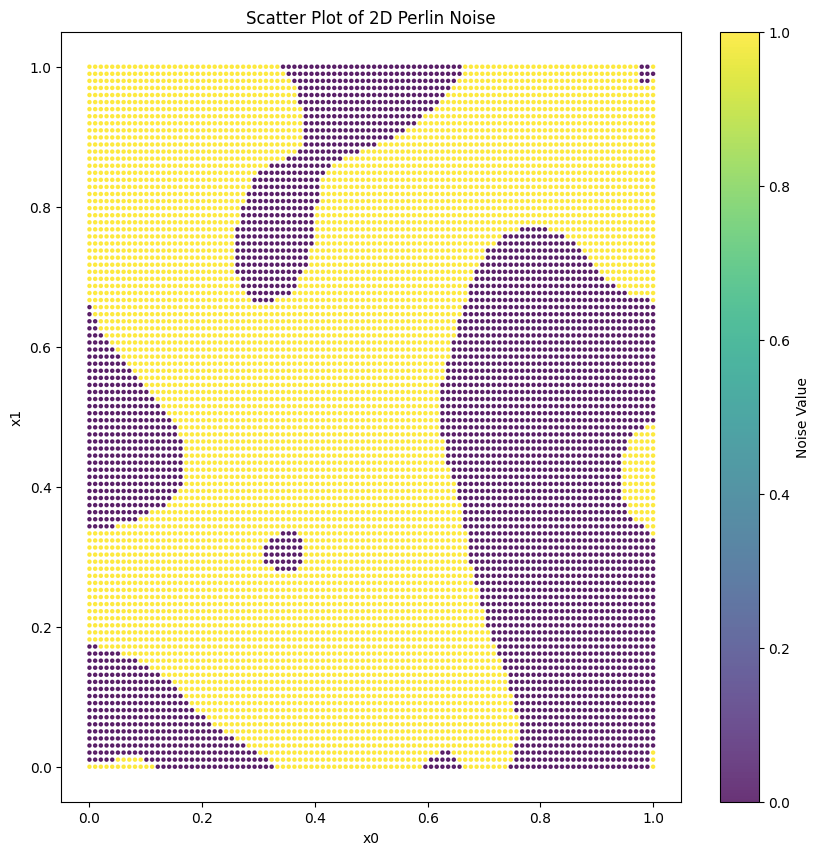

In [2]:
generator_2D = PerlinNoiseGenerator(res=[100, 100], octv=3, seed=42, time_test=False)

xdataset_2D = generator_2D.perlin_data_xarray()

generator_2D.plot_2D_xarray()


Best parameters: {'C': 10, 'gamma': 100}


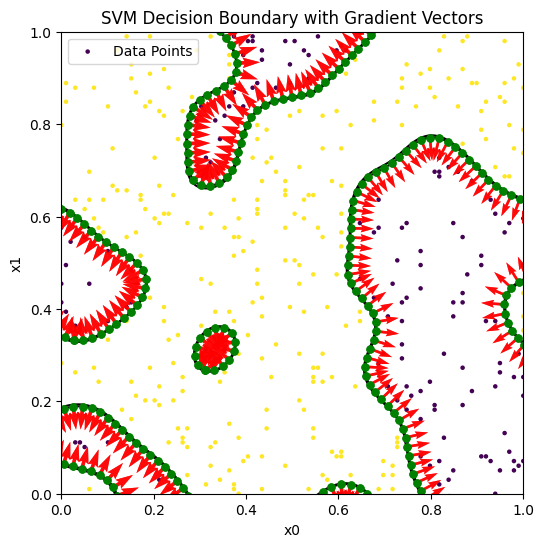

In [3]:
boundary_points, gradients = svm_boundary_2D(sample_xarray(xdataset_2D, 400), boundary_resolution_len=0.02, plot=True)

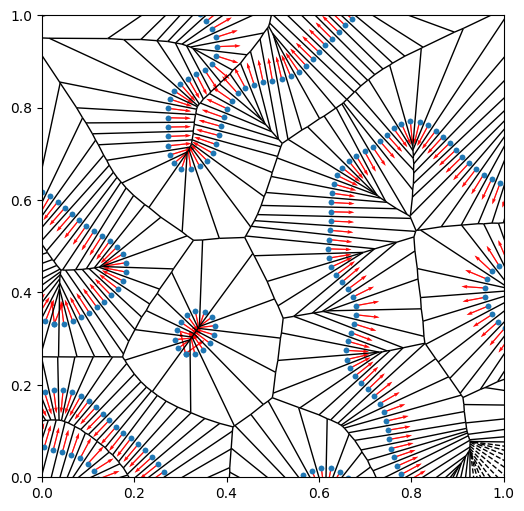

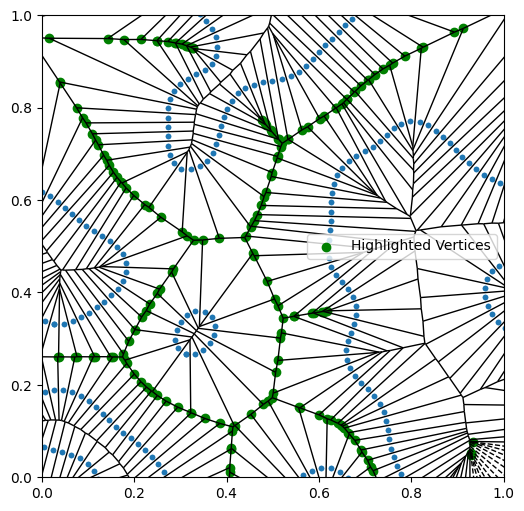

In [4]:
vor = voronoi_points(boundary_points, gradients, plot=True)
midpath_coords = compute_sink_vertices(boundary_points, gradients, plot=True)

In [5]:
# import numpy as np
# import matplotlib.pyplot as plt
# # from shapely.geometry import Polygon
# from matplotlib.patches import Polygon as MplPolygon
# from scipy.spatial import ConvexHull






# outward_boundary_points = combined_boundary_points + 0.1 * combined_gradients  # Scale factor for extension

# # Compute outward region area (using boundary points and outward points)
# outward_hull = ConvexHull(outward_boundary_points)
# outward_area = outward_hull.volume

# # Plot original boundary and outward region
# fig, ax = plt.subplots(figsize=(8, 6))

# # Plot the original boundary polygon
# original_patch = MplPolygon(combined_boundary_points, closed=True, edgecolor='blue', alpha=0.5, label='Original Boundary')
# ax.add_patch(original_patch)

# # Plot the outward polygon
# outward_patch = MplPolygon(outward_boundary_points, closed=True, facecolor='yellow', alpha=0.3, label='Outward Region')
# ax.add_patch(outward_patch)

# # Add gradient vectors for visualization
# for p, g in zip(combined_boundary_points, gradients):
#     ax.arrow(p[0], p[1], 0.1 * g[0], 0.1 * g[1], head_width=0.02, color='red', alpha=0.8)

# # Plot boundary points
# ax.scatter(combined_boundary_points[:, 0], combined_boundary_points[:, 1], color='green', label='Boundary Points')

# # Configure plot
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.legend()
# ax.set_title(f'Outward Region Highlighted (Area: {outward_area:.3f})')

# plt.show()
